In [925]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import datetime
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import grangercausalitytests

In [926]:
nasdaq = yf.download('^IXIC', start='2013-01-01', end='2023-01-01')
nse = yf.download('^NSEI', start='2013-01-01', end='2023-01-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [927]:
data = pd.merge(nasdaq, nse, on='Date', suffixes=('_NASDAQ', '_NSE'), how='inner')

In [928]:
df2 = data.index.tolist()
f=list(df2)

In [929]:
data['Returns_NASDAQ'] = data['Close_NASDAQ'].pct_change()
data['Returns_NSE'] = data['Close_NSE'].pct_change()


In [930]:
correaltion_coefficient=(data['Returns_NASDAQ'].dropna()).corr(data['Returns_NSE'].dropna())


Correlation Analysis

In [931]:
correaltion_coefficient

0.28050435186356704

Using Granger Casuality for identifying lead-lag relationship

In [932]:
data1=pd.DataFrame({'Returns_NASDAQ': data['Returns_NASDAQ'].dropna(), 'Returns_NSE': data['Returns_NSE'].dropna().dropna()})
max_lag=5
granger_test_nasdaq_to_nse = grangercausalitytests(data1[['Returns_NASDAQ', 'Returns_NSE']], max_lag, verbose=True)
granger_test_nse_to_nasdaq = grangercausalitytests(data1[['Returns_NSE', 'Returns_NASDAQ']], max_lag, verbose=True)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6175 , p=0.0011  , df_denom=2386, df_num=1
ssr based chi2 test:   chi2=10.6308 , p=0.0011  , df=1
likelihood ratio test: chi2=10.6072 , p=0.0011  , df=1
parameter F test:         F=10.6175 , p=0.0011  , df_denom=2386, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.6404  , p=0.0001  , df_denom=2383, df_num=2
ssr based chi2 test:   chi2=19.3213 , p=0.0001  , df=2
likelihood ratio test: chi2=19.2436 , p=0.0001  , df=2
parameter F test:         F=9.6404  , p=0.0001  , df_denom=2383, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.4149  , p=0.0001  , df_denom=2380, df_num=3
ssr based chi2 test:   chi2=22.3100 , p=0.0001  , df=3
likelihood ratio test: chi2=22.2064 , p=0.0001  , df=3
parameter F test:         F=7.4149  , p=0.0001  , df_denom=2380, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.3226  , p=0.

In [933]:
p_values_nasdaq_to_nse = [granger_test_nasdaq_to_nse[i+1][0]['ssr_ftest'][1] for i in range(max_lag)]
print(f"P-values for NASDAQ leading NSE: {p_values_nasdaq_to_nse}")
p_values_nse_to_nasdaq = [granger_test_nse_to_nasdaq[i+1][0]['ssr_ftest'][1] for i in range(max_lag)]
print(f"P-values for NSE leading NASDAQ: {p_values_nse_to_nasdaq}")

P-values for NASDAQ leading NSE: [0.001135962823521748, 6.761684323854026e-05, 6.0825338820642076e-05, 7.378281434487781e-06, 4.645025889457947e-07]
P-values for NSE leading NASDAQ: [5.50600346033213e-37, 2.1890373634273614e-39, 1.982576965616632e-38, 1.6416999613647108e-37, 1.2319305287623886e-35]


 NSE consistently leads NASDAQ across various lag lengths

 NSE consistently leads NASDAQ with extremely low p-values across all tested lags. Therefore, NSE should be considered for parameter optimization.

NASDAQ shows strong evidence of leading NSE across various lags, though the evidence is not as overwhelming as NSE leading NASDAQ. Therefore, NASDAQ may be more suitable for trading purposes.

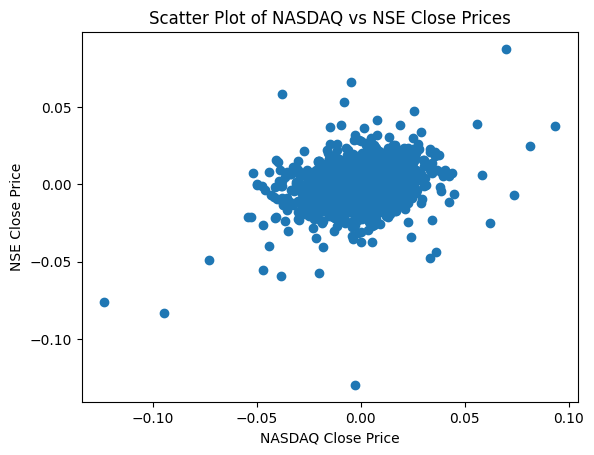

In [934]:
plt.scatter(data['Returns_NASDAQ'],data['Returns_NSE'])
plt.xlabel('NASDAQ Close Price')
plt.ylabel('NSE Close Price')
plt.title('Scatter Plot of NASDAQ vs NSE Close Prices')
plt.show()

Indicator Coding

ATR

In [935]:
def ATR(data,n):
    df=data.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-Cp']=abs((df['High']-df['Close']).shift(1))
    df['L-Cp']=abs((df['Low']-df['Close']).shift(1))
    df['TR']=df[['H-L','H-Cp','L-Cp']].max(axis=1)
    df['ATR']=df['TR'].ewm(span=n,adjust=False).mean()
    df=df.drop(['H-L','H-Cp','L-Cp'],axis=1)
    return df

MACD

In [936]:
def MACD(data):
    data['MACD']=data['Close'].ewm(span=12,adjust=False).mean()-data['Close'].ewm(span=26,adjust=False).mean()
    data['Signal']=data['MACD'].ewm(span=9,adjust=False).mean()
    return data

Bollinger Band

In [937]:
def BollingerBand(data,window=10,standard_dev=2):
    data['sma']=data['Close'].rolling(window=window).mean()
    data['sd']=data['Close'].rolling(window=window).std()
    data['Lower_Band']=data['sma']-standard_dev*data['sd']
    data['Upper_Band']=data['sma']+standard_dev*data['sd']
    data.drop('sd',axis=1,inplace=True)
    return data


Keltner Channel

In [938]:
def KeltnerChannel(data,window=30,multiplier=1):
    data['middle']=data['Close'].ewm(span=window,adjust=False).mean()
    data=ATR(data,window)
    data['upper']=data['middle']+multiplier*data['ATR']
    data['lower']=data['middle']-multiplier*data['ATR']
    return data


In [939]:
data

,Open_NASDAQ,High_NASDAQ,Low_NASDAQ,Close_NASDAQ,Adj Close_NASDAQ,Volume_NASDAQ,Open_NSE,High_NSE,Low_NSE,Close_NSE,Adj Close_NSE,Volume_NSE,Returns_NASDAQ,Returns_NSE
Date,,,,,,,,,,,,,,
2013-01-02,3091.330078,3112.649902,3083.489990,3112.260010,3112.260010,2111300000,5982.600098,6006.049805,5982.000000,5993.250000,5993.250000,0,NaN,NaN
2013-01-03,3108.489990,3118.179932,3092.280029,3100.570068,3100.570068,1769420000,6015.799805,6017.000000,5986.549805,6009.500000,6009.500000,0,-0.003756,0.002711
2013-01-04,3100.879883,3108.439941,3090.810059,3101.659912,3101.659912,1745140000,6011.950195,6020.750000,5981.549805,6016.149902,6016.149902,0,0.000351,0.001107
2013-01-07,3089.169922,3102.350098,3083.879883,3098.810059,3098.810059,1702540000,6042.149902,6042.149902,5977.149902,5988.399902,5988.399902,0,-0.000919,-0.004613
2013-01-08,3098.459961,3103.389893,3076.600098,3091.810059,3091.810059,1744380000,5983.450195,6007.049805,5964.399902,6001.700195,6001.700195,0,-0.002259,0.002221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,10437.750000,10514.759766,10361.820312,10497.860352,10497.860352,3544680000,17977.650391,18050.449219,17779.500000,17806.800781,17806.800781,221500,0.002075,-0.017683
2022-12-27,10462.190430,10472.320312,10340.730469,10353.230469,10353.230469,3827290000,18089.800781,18149.250000,17967.449219,18132.300781,18132.300781,214300,-0.013777,0.018280
2022-12-28,10339.200195,10414.820312,10207.469727,10213.290039,10213.290039,3842970000,18084.750000,18173.099609,18068.349609,18122.500000,18122.500000,193900,-0.013517,-0.000541


In [940]:
data2={
    'Open':data['Open_NASDAQ'],
    'High':data['High_NASDAQ'],
    'Low':data['Low_NASDAQ'],
    'Volume':data['Volume_NASDAQ'],
    'Close':data['Close_NASDAQ']

}
data2=pd.DataFrame(data2)

In [941]:
data3={
    'Open':data['Open_NSE'],
    'High':data['High_NSE'],
    'Low':data['Low_NSE'],
    'Volume':data['Volume_NSE'],
    'Close':data['Close_NSE']
}
data3=pd.DataFrame(data3)

In [942]:
data3

,Open,High,Low,Volume,Close
Date,,,,,
2013-01-02,5982.600098,6006.049805,5982.000000,0,5993.250000
2013-01-03,6015.799805,6017.000000,5986.549805,0,6009.500000
2013-01-04,6011.950195,6020.750000,5981.549805,0,6016.149902
2013-01-07,6042.149902,6042.149902,5977.149902,0,5988.399902
2013-01-08,5983.450195,6007.049805,5964.399902,0,6001.700195
...,...,...,...,...,...
2022-12-23,17977.650391,18050.449219,17779.500000,221500,17806.800781
2022-12-27,18089.800781,18149.250000,17967.449219,214300,18132.300781
2022-12-28,18084.750000,18173.099609,18068.349609,193900,18122.500000


In [943]:
capital=10000
portfolio_value=[]
quantity=[]
entry=[]
exit=[]
new_signal=[]
signal=[]
trade_type=[]
current_trade_peak=0
stop_loss_count=[]
take_profit_count=[]
win=0
loss=0

BackTesting Code

Signal Generation

In [944]:
data2=MACD(data2)
data2=BollingerBand(data2)
data2=KeltnerChannel(data2)
data3=MACD(data3)
data3=BollingerBand(data3)
data3=KeltnerChannel(data3)

MACD Signal

In [945]:
S1_Signal=[0]
for i in range(1,len(data)):
    if data3['MACD'].iloc[i]>data3['Signal'].iloc[i] and data3['MACD'].iloc[i-1]<data3['Signal'].iloc[i-1]:
        S1_Signal.append(1)
    elif data3['MACD'].iloc[i]<data3['Signal'].iloc[i] and data3['MACD'].iloc[i-1]>data3['Signal'].iloc[i-1]:
        S1_Signal.append(-1)
    else:
        S1_Signal.append(0) 

Bollinger Signal

In [946]:
Bollinger_Signal=[]
for i in range(len(data)):
    if data3['Close'].iloc[i]>data3['Upper_Band'].iloc[i]:
        Bollinger_Signal.append(1)
    elif data3['Close'].iloc[i]<data3['Lower_Band'].iloc[i]:
        Bollinger_Signal.append(-1)
    else:
        Bollinger_Signal.append(0)      

Keltner Channel

In [947]:
Keltner_Signal=[0]
for i in range(1,len(data)):
    if data3['Close'].iloc[i]>data3['upper'].iloc[i]:
        Keltner_Signal.append(1)
    elif data3['Close'].iloc[i]<data3['lower'].iloc[i]:
        Keltner_Signal.append(-1)
    else:
        Keltner_Signal.append(0)  

In [948]:
data3['signals']=Keltner_Signal

Backtesting Code

In [949]:

def Backtesting(data,cap,stop_p=0.0675,take_p=0.15,dynamic_exit_percent=0.2,multi=0.02):
    capital=cap
    win=0
    loss=0
    atr_stop_loss=0
    atr_dynamic_exit=0
    portfolio_value=[]
    quantity=[]
    current_position=0
    holding=0
    current_portfolio_value=0
    current_stop_loss=0
    current_take_profit=0
    stop_loss_percent=stop_p
    take_profit_percent=take_p
    entry=[]
    exit=[]
    new_signal=[]
    signal=list(data['signals'])
    trade_type=[]
    current_trade_peak=0
    dynamic_exits=[]
    dynamic_exit=0
    stop_loss_count=[]
    take_profit_count=[]
    profit_loss=[]
    duration=[]
    multiplier=1
    for i in range(len(data)-1):
      if capital<0:
         print('Capital vanished')
      if current_position==0:
         if signal[i]==0:
            current_position=0
            new_signal.append(0)
            holding=0
            portfolio_value.append(capital)
            quantity.append(0)
         elif signal[i]==1:
            current_position=1
            holding=capital/data['Close'].iloc[i]
            capital=0
            new_signal.append(1)
            quantity.append(holding)
            current_portfolio_value=holding*data['Close'].iloc[i]
            portfolio_value.append(current_portfolio_value)
            entry.append(i)
            trade_type.append('Long')
            current_trade_peak=current_portfolio_value
            atr_stop_loss = current_portfolio_value - data['ATR'].iloc[i]*multi
            current_stop_loss=(1-stop_loss_percent)*current_trade_peak
            current_take_profit=(1+take_profit_percent)*current_trade_peak

         elif signal[i]==-1:
            current_position=-1
            holding=capital/data['Close'].iloc[i]
            capital=2*capital
            new_signal.append(-1)
            quantity.append(holding)
            current_portfolio_value=capital-holding*data['Close'].iloc[i]
            portfolio_value.append(current_portfolio_value)
            entry.append(i)
            trade_type.append('Short')
            current_trade_peak=current_portfolio_value
            dynamic_exit=(1+dynamic_exit_percent)*current_trade_peak
            atr_dynamic_exit = current_portfolio_value + data['ATR'][i]*multi
            current_stop_loss=(1+stop_loss_percent)*current_trade_peak
            current_take_profit=(1-take_profit_percent)*current_trade_peak

      elif current_position==1:
         if signal[i]==0 or signal[i]==1:
            temp=holding*data['Close'].iloc[i]
            if temp<current_stop_loss or temp<atr_stop_loss:
               stop_loss_count.append(i)
               current_position=0
               quantity.append(0)
               capital=holding*data['Close'].iloc[i]
               current_portfolio_value=capital
               portfolio_value.append(current_portfolio_value)
               exit.append(i)
               duration.append(exit[-1]-entry[-1])
               net=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
               profit_loss.append(net)   
               new_signal.append(-1)
               if net>0:
                   win=win+1
               else:
                   loss=loss+1 
            elif temp>=current_take_profit:
               take_profit_count.append(i)
               current_position=0
               quantity.append(0)
               capital=holding*data['Close'].iloc[i]
               current_portfolio_value=capital
               portfolio_value.append(current_portfolio_value)
               exit.append(i)
               duration.append(exit[-1]-entry[-1])
               net=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
               profit_loss.append(net)
               new_signal.append(-1)
               if net>0:
                   win=win+1
               else:
                   loss=loss+1 
            elif holding*data['Close'].iloc[i]>current_trade_peak:
               current_trade_peak=holding*data['Close'].iloc[i]
               current_stop_loss=(1-stop_loss_percent)*current_trade_peak
               atr_stop_loss = current_portfolio_value - data['ATR'][i]*multi
               current_position=1
               quantity.append(holding)
               current_portfolio_value=holding*data['Close'].iloc[i]
               portfolio_value.append(current_portfolio_value)
               new_signal.append(0)
            else:
               current_position=1
               quantity.append(holding)
               current_portfolio_value=holding*data['Close'].iloc[i]
               portfolio_value.append(current_portfolio_value)
               new_signal.append(0)   
         else:
            current_position=0
            quantity.append(0)
            capital=holding*data['Close'].iloc[i]
            current_portfolio_value=capital
            portfolio_value.append(current_portfolio_value)
            exit.append(i)
            duration.append(exit[-1]-entry[-1])
            net=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
            profit_loss.append(net)
            new_signal.append(-1)
            if net>0:
                   win=win+1
            else:
                   loss=loss+1

      elif current_position==-1:
        if signal[i]==0 or signal[i]==-1:
           temp=capital-holding*data['Close'].iloc[i]
           if temp>current_stop_loss:
                stop_loss_count.append(i)
                current_position=0
                quantity.append(0)
                capital=capital-holding*data['Close'].iloc[i]
                current_portfolio_value=capital
                portfolio_value.append(current_portfolio_value)
                exit.append(i)
                duration.append(exit[-1]-entry[-1])
                net=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                profit_loss.append(net)
                new_signal.append(1)
                if net>0:
                   win=win+1
                else:
                   loss=loss+1
           elif temp>dynamic_exit or temp>atr_dynamic_exit:
                dynamic_exits.append(i)
                current_position=0
                quantity.append(0)
                capital=capital-holding*data['Close'].iloc[i]
                current_portfolio_value=capital
                portfolio_value.append(current_portfolio_value)
                exit.append(i)
                duration.append(exit[-1]-entry[-1])
                net=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                profit_loss.append(net)
                new_signal.append(1)
                if net>0:
                   win=win+1
                else:
                   loss=loss+1
                      
           elif temp<=current_take_profit:
                take_profit_count.append(i)
                current_position=0
                quantity.append(0)
                capital=capital-holding*data['Close'].iloc[i]
                current_portfolio_value=capital
                portfolio_value.append(current_portfolio_value)
                exit.append(i)
                duration.append(exit[-1]-entry[-1])
                net=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                profit_loss.append(net)
                new_signal.append(1)
                if net>0:
                   win=win+1
                else:
                   loss=loss+1
           elif (capital-holding*data['Close'].iloc[i])<current_trade_peak:
                multiplier=(current_trade_peak-capital)/current_trade_peak
                current_trade_peak=capital-holding*data['Close'].iloc[i]
                current_stop_loss=(1+stop_loss_percent)*current_trade_peak
                dynamic_exit=(1+dynamic_exit_percent)*multiplier*current_trade_peak
                atr_dynamic_exit = current_portfolio_value + data['ATR'][i]*multi
                current_position=-1
                quantity.append(holding)
                current_portfolio_value=capital-holding*data['Close'].iloc[i]
                portfolio_value.append(current_portfolio_value)
                new_signal.append(0)
           else:
                current_position=-1
                quantity.append(holding)
                current_portfolio_value=capital-holding*data['Close'].iloc[i]
                portfolio_value.append(current_portfolio_value)
                new_signal.append(0)
                    
        else:
           current_position=0
           capital=capital-holding*data['Close'].iloc[i]
           quantity.append(0)
           current_portfolio_value=capital
           portfolio_value.append(current_portfolio_value)
           exit.append(i)
           duration.append(exit[-1]-entry[-1])
           net=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
           profit_loss.append(net)
           new_signal.append(1)
           if net>0:
                   win=win+1
           else:
                   loss=loss+1    

    if current_position==1:
            current_position=0
            quantity.append(0)
            capital=holding*data['Close'].iloc[i]
            current_portfolio_value=capital
            portfolio_value.append(current_portfolio_value)
            exit.append(i)
            duration.append(exit[-1]-entry[-1])
            net=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
            profit_loss.append(net)
            new_signal.append(-1)
            if net>0:
                   win=win+1
            else:
                   loss=loss+1
    elif current_position==-1:
           current_position=0
           capital=capital-holding*data['Close'].iloc[i]
           quantity.append(0)
           current_portfolio_value=capital
           portfolio_value.append(current_portfolio_value)
           exit.append(i)
           duration.append(exit[-1]-entry[-1])
           net=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
           profit_loss.append(net)
           new_signal.append(1)
           if net>0:
                   win=win+1
           else:
                   loss=loss+1
    else:
            current_position=0
            new_signal.append(0)
            holding=0
            portfolio_value.append(capital)
            quantity.append(0)

    print(f'Win-{win}')
    print(f'Loss-{loss}')     
    a=pd.DataFrame(columns=['Entry'])
    a['Entry']=entry
    a['Exit']=exit
    a['Duration']=duration
    a['Profit/Loss']=profit_loss
    a['Trade Type']=trade_type
    print("Stop Loss hit:",len(stop_loss_count))
    print("Take Profit hit:",len(take_profit_count))
    print("Dynamic exit hit:",len(dynamic_exits))
   #  to_submit=pd.DataFrame(columns=['Date'])
   #  to_submit['Date']=data['Date']
   #  to_submit['Open']=data['Open']
   #  to_submit['High']=data['High']
   #  to_submit['Low']=data['Low']
   #  to_submit['Close']=data['Close']
   #  to_submit['Volume']=data['Volume']
   #  to_submit['signals']=new_signal
    return capital,portfolio_value,quantity,entry,exit,new_signal,trade_type,stop_loss_count,take_profit_count,win,loss,a

capital,portfolio_value,quantity,entry,exit,new_signal,trade_type,stop_loss_count,take_profit_count,win,loss,a=Backtesting(data3,capital)
print(f'Returns={capital-10000/10000}')           

Win-243
Loss-241
Stop Loss hit: 259
Take Profit hit: 0
Dynamic exit hit: 222
Returns=22020.583741983235


After Parameter Optimization,we can clearly see that NASDAQ paramters is able to generate more wins when applied to NSE index